## Unstructured data (or unstructured information) is information that either does not have a pre-defined data model or is not organized in a pre-defined manner. Unstructured information is typically text-heavy, but may contain data such as dates, numbers, and facts as well.

##                                                                              — Wikipedia description of unstructured data.

In [5]:
#Import useful libs

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Read in train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [28]:
print('General information of Training data \n')
print(train.info())
print('\n')
print('General information of Test data \n')
print(test.info())


General information of Training data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


General information of Test data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.0+ KB
None


# Note:

## 1. The "id" variable is not consecutive
## 2. The "location" varaibles have a lot of missing values


# Data description:

## 1. "id": a unique identifier for each tweet

## 2. "keyword": a particular keyword from the tweet (may be blank)

## 3. "location": the location the tweet was sent from (may be blank)

## 4. "target": in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

# Step1: EDA

In [27]:
print('General information of Training data \n')
print(train.describe())
print('\n')

print('General information of Test data \n')
print(test.describe())

General information of Training data 

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


General information of Test data 

                 id
count   3263.000000
mean    5427.152927
std     3146.427221
min        0.000000
25%     2683.000000
50%     5500.000000
75%     8176.000000
max    10875.000000


In [12]:
pandas_profiling.ProfileReport(train)

NameError: name 'pandas_profiling' is not defined

## 1.1 The "location" variable has large number of missing values, however, I think it is an important feature to identify whether the tweets is real, I decided to look at the value_counts of the variable for both train and test data

## Purpose:

### 1. Check the spread of the location
### 2. Check if there's any invalid data for the location
### 3. Check whether the test data have the location that train data do not have


In [14]:
train.location.value_counts()

USA                               104
New York                           71
United States                      50
London                             45
Canada                             29
Nigeria                            28
UK                                 27
Los Angeles, CA                    26
India                              24
Mumbai                             22
Washington, DC                     21
Kenya                              20
Worldwide                          19
Chicago, IL                        18
Australia                          18
California                         17
California, USA                    15
New York, NY                       15
Everywhere                         15
United Kingdom                     14
Florida                            14
San Francisco                      14
Los Angeles                        13
Washington, D.C.                   13
Indonesia                          13
NYC                                12
Ireland     

In [15]:
test.location.value_counts()

New York                         38
USA                              37
Worldwide                        16
United States                    15
Canada                           13
London                           13
Kenya                            12
Nigeria                          12
United Kingdom                   12
Los Angeles                      11
India                            11
Washington, DC                   10
San Francisco, CA                 9
San Francisco                     9
NYC                               9
Philippines                       9
California                        8
Los Angeles, CA                   8
Seattle, WA                       7
Australia                         7
Florida                           7
Singapore                         7
New York, NY                      7
Chicago                           6
Mumbai                            6
Melbourne, Australia              6
UK                                6
California, USA             

In [31]:
#Compare locations in train and test
loc_train = train.location.dropna(axis = 0).values
loc_test = test.location.dropna(axis = 0).values

x = set(loc_test).issubset(loc_train)
x


False

## ***Findings after rough check of the "location" variable:

### 1. For both train and test data, the format of observations were not unified 
###  e.g., USA and United States are actually same country  ---> should be corrected

### 2. For the location, there are belonging relationships; e.g., CA belongs to USA ----> should consider creating another column to indicate. In addition, considering to have consistent unit for location, for example, Country, State, County etc..

### 3. There are invalid records; e.g., ??? in training data; 3-Jan in test data

### 4. There are locations that in test data do not belong to test data, should figure them out

### 5. How to fill missing values?


## 1.2 About "keyword" variable

### Some thoughts: 

### Since there are some missing values for the "keyword" variable, how to fill the missing values is critical； I think it might be better to take a look at the nonmissing values and find a rule of how the keywords were extracted from text

In [34]:
#Check the most frequent keywords
key_freq = train.keyword.value_counts()[:20]

fatalities     45
deluge         42
armageddon     42
sinking        41
body%20bags    41
harm           41
damage         41
evacuate       40
twister        40
collided       40
outbreak       40
fear           40
siren          40
windstorm      40
whirlwind      39
derailment     39
wreckage       39
famine         39
weapon         39
weapons        39
Name: keyword, dtype: int64

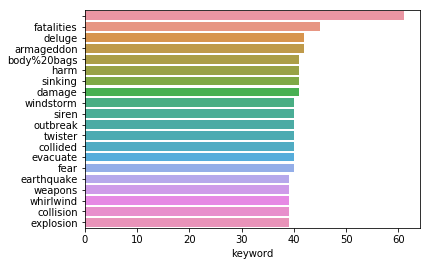

In [14]:
keyword = train['keyword'].value_counts()[:20]

#show the freq of keyword
_ = sns.barplot(x = keyword, y = keyword.index)

In [25]:
#Find the keyword with high probability of predicting a disaster
prob = train.groupby('keyword').agg({'text': 'count', 'target': 'mean'}).rename(columns = {'text':'Count', 'target':'Probability'})

prob.sort_values(by ='Probability', ascending = False)[:20]


,Count,Probability
keyword,,
wreckage,39,1.000000
debris,37,1.000000
derailment,39,1.000000
outbreak,40,0.975000
oil%20spill,38,0.973684
typhoon,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.931034


## Thoughts: Can create a new variable to distinguish keyword with different ranges of probabilities of predicting target

## Range proposed: 1, above .9-1, above .7-.9, below .5

### Thoughts:

### 1. Corrrect the location 
### 1.1. Split it into two columns: city and country
### 1.2 Check the distributions of target based on city/country